# Jinx 833 Challenger EUW - Sanity Test

## Load Dataset

In [92]:
from tlol.datasets.replay_dataset import *
dataset = TLoLReplayDataset(
    "./full_db",
    obs_per_scene=4)

In [93]:
dataset[0]["raw"]["time"]

0         5.292969
1         6.445312
2         6.699219
3         6.832031
4         6.964844
           ...    
1405    298.750000
1406    299.000000
1407    299.250000
1408    299.500000
1409    299.750000
Name: time, Length: 1410, dtype: float16

In [94]:
dataset[0]["champs"].columns[0:65]

Index(['health_0', 'max_health_0', 'team_0', 'armour_0', 'mr_0',
       'movement_speed_0', 'is_alive_0', 'position_x_0', 'position_y_0',
       'position_z_0', 'is_moving_0', 'targetable_0', 'invulnerable_0',
       'recallState_0', 'q_level_0', 'q_cd_0', 'w_level_0', 'w_cd_0',
       'e_level_0', 'e_cd_0', 'r_level_0', 'r_cd_0', 'd_level_0', 'd_cd_0',
       'd_summoner_spell_type_0', 'f_level_0', 'f_cd_0',
       'f_summoner_spell_type_0', 'crit_0', 'critMulti_0', 'level_0', 'mana_0',
       'max_mana_0', 'ability_haste_0', 'ap_0', 'lethality_0', 'experience_0',
       'mana_regen_0', 'health_regen_0', 'attack_range_0', 'current_gold_0',
       'total_gold_0', 'prev_position_x_0', 'prev_position_y_0',
       'prev_position_z_0', 'position_x_delta_0', 'position_z_delta_0',
       'position_x_z_delta_0', 'position_x_delta_digital_0',
       'position_z_delta_digital_0', 'q_prev_cd_0', 'w_prev_cd_0',
       'e_prev_cd_0', 'r_prev_cd_0', 'd_prev_cd_0', 'f_prev_cd_0', 'q_cast_0',
       

In [95]:
# dataset[0]["champs"].columns[0:65]
# dataset[0]["champs"].columns[0:14], len(dataset[0]["champs"].columns[0:14])
d = [dataset[0]["champs"].columns[(65*(i))+7:(65*(i))+10] for i in range(10)]
d

[Index(['position_x_0', 'position_y_0', 'position_z_0'], dtype='object'),
 Index(['position_x_1', 'position_y_1', 'position_z_1'], dtype='object'),
 Index(['position_x___', 'position_y___', 'position_z___'], dtype='object'),
 Index(['position_x_3___', 'position_y_3___', 'position_z_3___'], dtype='object'),
 Index(['position_x_4___', 'position_y_4___', 'position_z_4___'], dtype='object'),
 Index(['position_x___', 'position_y___', 'position_z___'], dtype='object'),
 Index(['position_x_2_', 'position_y_2_', 'position_z_2_'], dtype='object'),
 Index(['position_x_3___', 'position_y_3___', 'position_z_3___'], dtype='object'),
 Index(['position_x_4___', 'position_y_4___', 'position_z_4___'], dtype='object'),
 Index(['position_x_5_', 'position_y_5_', 'position_z_5_'], dtype='object')]

## Plot Jinx Position

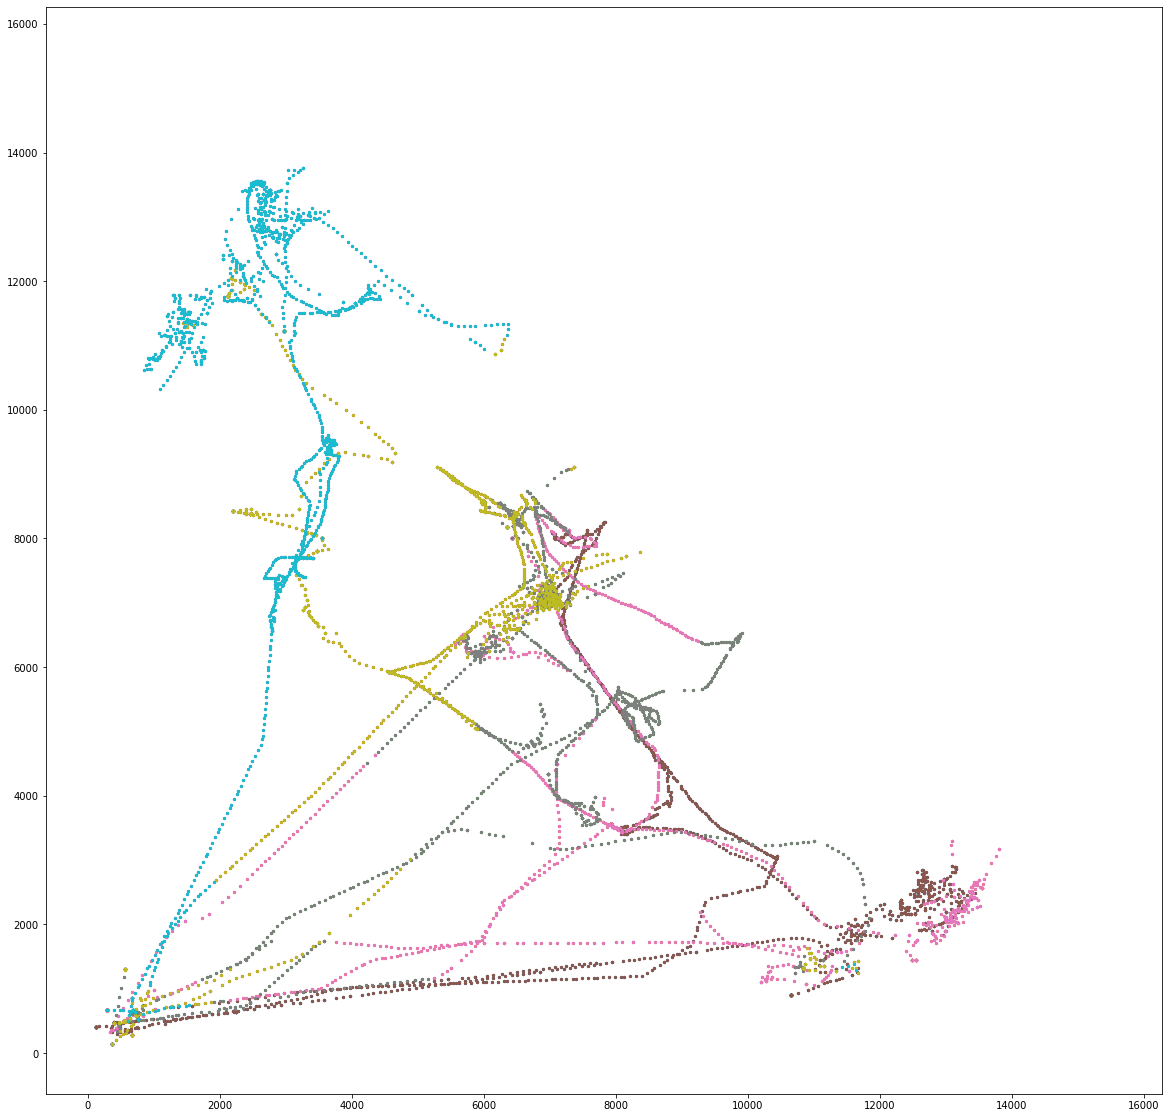

In [96]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
example = dataset[240]

champs   = example["champs"]
minions  = example["minions"]
turrets  = example["turrets"]
jungle   = example["jungle"]
others   = example["others"]
missiles = example["missiles"]

champ_pos_s = []

for i in range(10):
    champ_pos_x = champs.iloc[:, 7 + UNIT_FEATURE_COUNTS["champs"] * i]
    champ_pos_y = champs.iloc[:, 9 + UNIT_FEATURE_COUNTS["champs"] * i]
    champ_pos_s.append([champ_pos_x, champ_pos_y])
    plt.scatter(champ_pos_x, champ_pos_y, s=5)
    plt.scatter(15_500, 15_500, c="white")

champ_pos_x = champs.iloc[:, 7]
champ_pos_y = champs.iloc[:, 9]

## Visualise Global Intent Regions

In [97]:
global_region_mult = 2
map_dim  = 16_000
map_width = map_height = map_dim
map_n = int(map_dim / 1000) * global_region_mult
global_intent_region_size = int(map_dim / map_n)
print("Map Region Count, Map Region Size:", map_n, (global_intent_region_size, global_intent_region_size))

Map Region Count, Map Region Size: 32 (500, 500)


### Plot Global Intent Regions

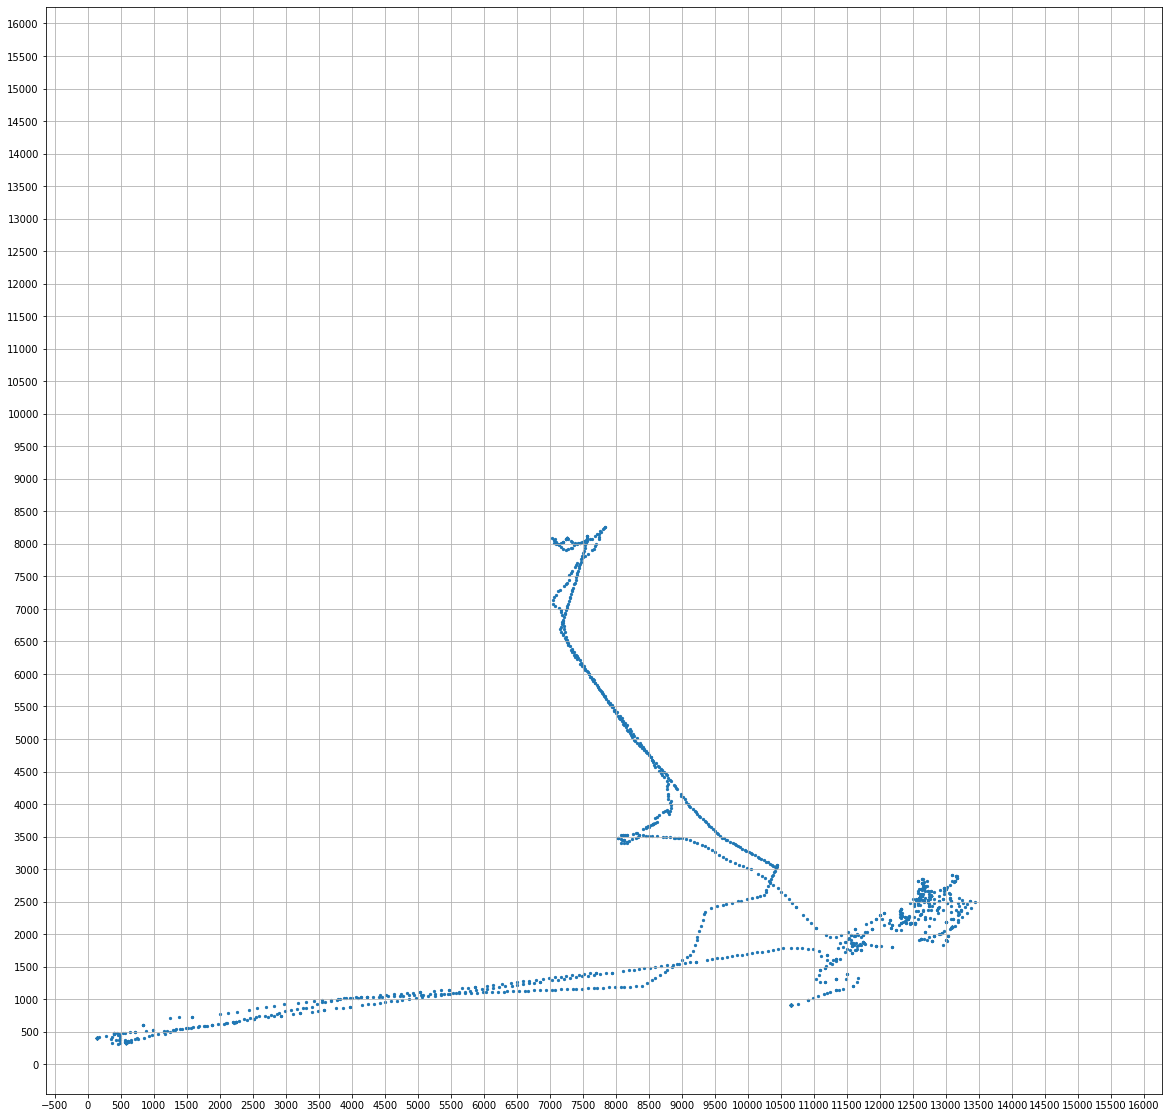

In [98]:
import matplotlib.ticker as plticker

def plot_global_intent_regions(x_pos, y_pos):
    fig, ax = plt.subplots()

    intervals = global_intent_region_size
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')

    ax.scatter(x_pos, y_pos, s=5)
    ax.scatter(15_500, 15_500, c="white")

for [champ_pos_x, champ_pos_y] in champ_pos_s[0:1]:
    plot_global_intent_regions(champ_pos_x, champ_pos_y)

### Visualise Global Intent Region Hotspots

#### Raw Global Intent Region Heatmap

In [99]:
champ_pos = pd.concat([champ_pos_x, champ_pos_y], axis=1)

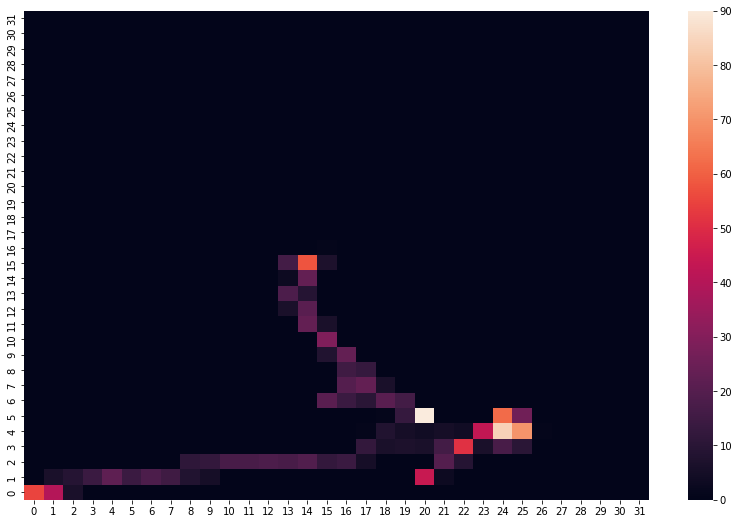

In [100]:
import math
import sys
import seaborn as sns
from numpy import interp

# Reset to default
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

def global_heatmap(pos_df):
    global_intent_sum_matrix = np.zeros((map_n, map_n))

    #%%timeit
    def inc_global_region(row, global_intent_sum_matrix):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row[0], [0, 16000], [0, map_n-1]))
        y_n = math.floor(interp(row[1], [0, 16000], [0, map_n-1]))
        global_intent_sum_matrix[y_n, x_n] += 1

    pos_df.apply(lambda row: inc_global_region(row, global_intent_sum_matrix), axis=1)
    np.set_printoptions(threshold=8)
    result = global_intent_sum_matrix

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    return result, global_intent_sum_matrix

result, global_intent_sum_matrix = global_heatmap(champ_pos)

#### Log10 Normalised Global Intent Region Heatmap

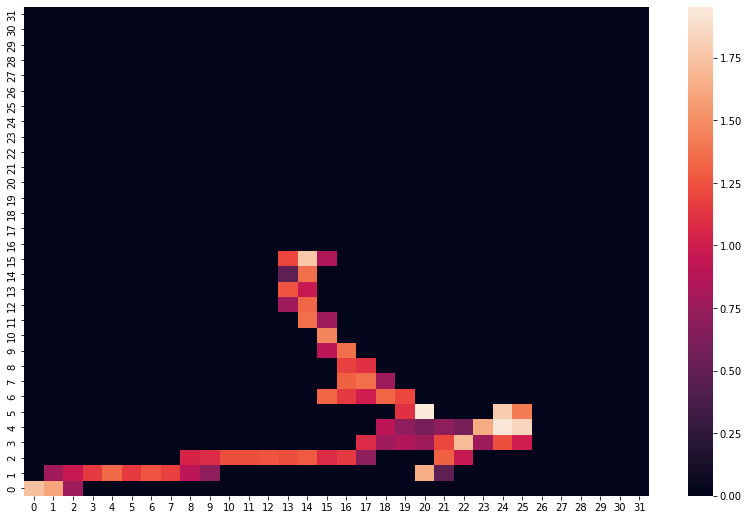

In [101]:
def global_heatmap_normalised(result, global_intent_sum_matrix):
    result = np.where(global_intent_sum_matrix > 0.0000001, global_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()

global_heatmap_normalised(result, global_intent_sum_matrix)

## Visualise Local Intent Regions

#### Set Local Intent Region Settings

In [102]:
map_m = int(global_intent_region_size / 50)
local_intent_region_size = int(global_intent_region_size / map_m)
print("Local Region Count, Local Region Size:", map_m, (global_intent_region_size, global_intent_region_size))

Local Region Count, Local Region Size: 10 (500, 500)


#### Get Global Intent Region with Highest Movement Activity

In [103]:
highest_activity_1d = result.argmax()
print("1D-index of highest activity region:", highest_activity_1d)

1D-index of highest activity region: 180


In [104]:
from numpy import unravel_index
highest_activity_2d = \
    unravel_index(global_intent_sum_matrix.argmax(), global_intent_sum_matrix.shape)
highest_activity_2d

(5, 20)

#### Plot Global Intent Region with Highest Movement Activity

10000 2500
cur_champ:      position_x_0  position_z_0
213       10064.0        2558.0
214       10136.0        2576.0
215       10176.0        2584.0
216       10240.0        2600.0
217       10272.0        2652.0
218       10280.0        2682.0
219       10304.0        2738.0
220       10328.0        2788.0
221       10336.0        2808.0
222       10352.0        2848.0
223       10368.0        2888.0
224       10376.0        2908.0
225       10400.0        2958.0
226       10408.0        2978.0
721       10152.0        2932.0
722       10208.0        2898.0
723       10256.0        2862.0
724       10320.0        2810.0
725       10384.0        2758.0
726       10448.0        2706.0
total number of points in local region: 20


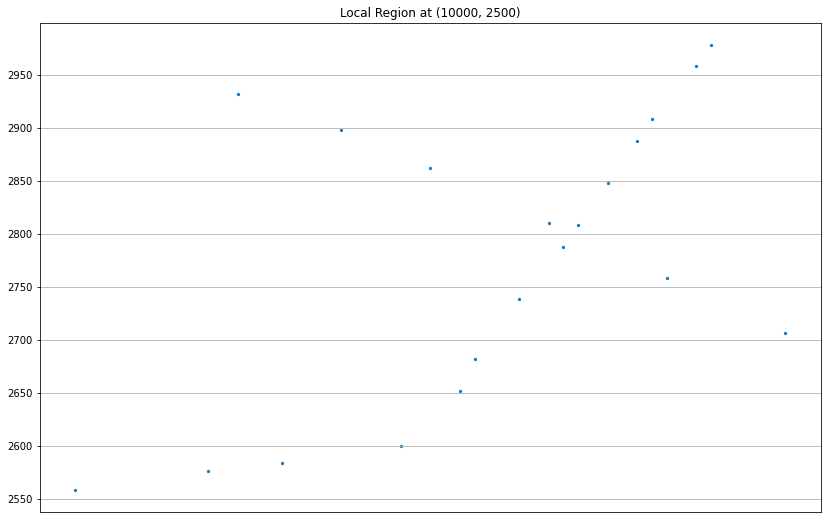

In [105]:
def get_local_actions(row, x_off, y_off):
    # global_intent_region_size
    x = row[0]
    y = row[1]
    """
    print(
        x,
        y,
        x_off,
        y_off,
        x_off + global_intent_region_size * 1,
        y_off + global_intent_region_size * 1,
        x >= x_off and x <= x_off + global_intent_region_size * 1,
        y >= y_off and y <= y_off + global_intent_region_size * 1)
    """
    if   x < x_off or x > x_off + global_intent_region_size * 1:
        return False
    elif y < y_off or y > y_off + global_intent_region_size * 1:
        return False
    else:
        return True

def get_local_actions_only(x_off, y_off, champ_series):
    print(x_off, y_off)
    mask = champ_series.apply(lambda row:\
                              get_local_actions(row, x_off, y_off), axis=1)
    champ_series = champ_series[mask]
    return champ_series

def plot_map_local_scatter(champ_pos, intervals, pos):    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    plt.title(f"Local Region at ({pos[1]*global_intent_region_size}, {pos[0]*global_intent_region_size})")

    # remove (0, 0) rows from a champ

    lens = 0
    cur_champ = get_local_actions_only(
        x_off=pos[1] * global_intent_region_size,
        y_off=pos[0] * global_intent_region_size,
        champ_series=champ_pos,
    )
    lens += len(cur_champ)
    print("cur_champ:", cur_champ)
    ax.scatter(cur_champ.iloc[:,0], cur_champ.iloc[:,1], s=5)
    print("total number of points in local region:", lens)

plot_map_local_scatter(
    champ_pos,
    local_intent_region_size,
    highest_activity_2d)

### Visualise Global Intent Region Hotspots

#### Raw Local Intent Region Heatmap

10000 2500
X, Y: 1 1
X, Y: 2 1
X, Y: 3 1
X, Y: 4 1
X, Y: 4 2
X, Y: 5 3
X, Y: 5 4
X, Y: 5 5
X, Y: 6 5
X, Y: 6 6
X, Y: 6 6
X, Y: 6 7
X, Y: 7 8
X, Y: 7 8
X, Y: 2 7
X, Y: 3 7
X, Y: 4 6
X, Y: 5 5
X, Y: 6 4
X, Y: 8 3


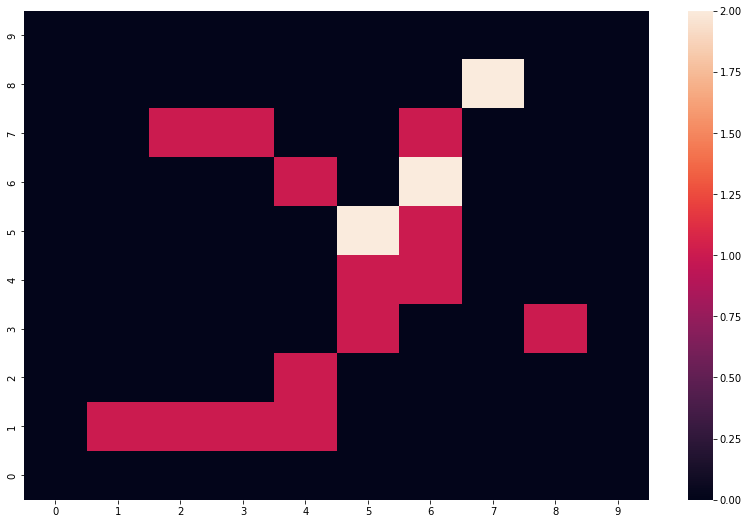

In [106]:
import math
import sys
import seaborn as sns
from numpy import interp

# Reset to default
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

def local_heatmap(champ_pos, pos):
    local_intent_sum_matrix = np.zeros((map_m, map_m))

    #%%timeit
    def inc_local_region(row, local_intent_sum_matrix, x_off, y_off):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row[0], [x_off + 0, x_off + global_intent_region_size], [0, map_m-1]))
        y_n = math.floor(interp(row[1], [y_off + 0, y_off + global_intent_region_size], [0, map_m-1]))
        
        print("X, Y:", x_n, y_n)
        local_intent_sum_matrix[y_n, x_n] += 1

    lens = 0
    x_off = pos[1] * global_intent_region_size
    y_off = pos[0] * global_intent_region_size
    cur_champ = get_local_actions_only(
        x_off=x_off,
        y_off=y_off,
        champ_series=champ_pos,
    )
    cur_champ.apply(lambda row: inc_local_region(row, local_intent_sum_matrix, x_off, y_off), axis=1)
    lens += len(cur_champ)

    np.set_printoptions(threshold=8)
    result = local_intent_sum_matrix

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    return result, local_intent_sum_matrix

result, local_intent_sum_matrix = \
    local_heatmap(champ_pos, highest_activity_2d)

#### Log10 Normalised Intent Region Heatmap

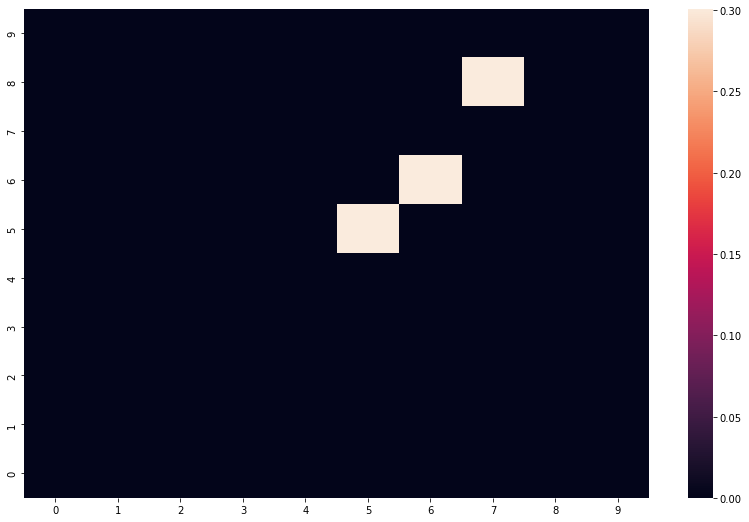

In [107]:
def local_heatmap_normalised(result, local_intent_sum_matrix):
    result = np.where(local_intent_sum_matrix > 0.0000001, local_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    

local_heatmap_normalised(result, local_intent_sum_matrix)

## Scene Identification

Scenes are determined using sliding window across player actions. \
Overlapping windows are dealt with using sensitive windows, i.e., \
if a higher priority action occurs even once within one window, \
that will be higher on the scene identification priority. \
Roughly 4.5 obs := 1 sec so 4 or 5 obs (or 1 sec of play) should be \
enough to classify each scene.

List of Scenes (By priority):
- [ ] Push-turret
   - Any autos on turret
- [ ] Combat
   - Autos on enemy
   - Spell usage (incl. summoners)
- [ ] Lane-farm
   - Any autos on minions
- [ ] Jungle-farm
   - Any autos on camps
- [ ] Return
   - Any recall action
- [ ] Navigation
   - None of above

### Identify Observations

In [108]:
"""
import enum
from multiprocessing import parent_process

class AutoTargetType(enum.IntEnum):
    CHAMP=0
    MINION=1
    TURRET=2
    JUNGLE=3
    OTHER=4

class Scene(enum.IntEnum):
    PUSH_TURRET=0
    COMBAT=1
    LANE_FARM=2
    JUNGLE_FARM=3
    RETURN=4
    NAVIGATION=5

def identify_row(row):
    using_auto = row["using_auto"]
    using_combat_spell = row[["using_w", "using_e", "using_d", "using_f"]].any()
    target_type = row["target_type"]

    if using_auto and target_type == AutoTargetType.TURRET:
        return Scene.PUSH_TURRET
    elif (using_auto and target_type == AutoTargetType.CHAMP) or using_combat_spell:
        return Scene.COMBAT
    elif using_auto:
        if target_type == AutoTargetType.CHAMP or \
             target_type == AutoTargetType.OTHER:
            return Scene.COMBAT
        if target_type == AutoTargetType.MINION:
            return Scene.LANE_FARM
        if target_type == AutoTargetType.JUNGLE:
            return Scene.JUNGLE_FARM
    elif row["using_recall"]:
        return Scene.RETURN
    else:
        return Scene.NAVIGATION
"""

'\nimport enum\nfrom multiprocessing import parent_process\n\nclass AutoTargetType(enum.IntEnum):\n    CHAMP=0\n    MINION=1\n    TURRET=2\n    JUNGLE=3\n    OTHER=4\n\nclass Scene(enum.IntEnum):\n    PUSH_TURRET=0\n    COMBAT=1\n    LANE_FARM=2\n    JUNGLE_FARM=3\n    RETURN=4\n    NAVIGATION=5\n\ndef identify_row(row):\n    using_auto = row["using_auto"]\n    using_combat_spell = row[["using_w", "using_e", "using_d", "using_f"]].any()\n    target_type = row["target_type"]\n\n    if using_auto and target_type == AutoTargetType.TURRET:\n        return Scene.PUSH_TURRET\n    elif (using_auto and target_type == AutoTargetType.CHAMP) or using_combat_spell:\n        return Scene.COMBAT\n    elif using_auto:\n        if target_type == AutoTargetType.CHAMP or              target_type == AutoTargetType.OTHER:\n            return Scene.COMBAT\n        if target_type == AutoTargetType.MINION:\n            return Scene.LANE_FARM\n        if target_type == AutoTargetType.JUNGLE:\n            retu

### Identify Scenes

In [109]:
"""
def identify_rows(rows, i, j):
    data = rows[i:j]
    if Scene.PUSH_TURRET in data:
        return Scene.PUSH_TURRET
    elif Scene.COMBAT in data:
        return Scene.COMBAT
    elif Scene.LANE_FARM in data:
        return Scene.LANE_FARM
    elif Scene.JUNGLE_FARM in data:
        return Scene.JUNGLE_FARM
    elif Scene.RETURN in data:
        return Scene.RETURN
    else:
        return Scene.NAVIGATION
        
OBS_PER_SCENE = 4

scene_dfs   = []

def get_scenes(data):
    cur_acts   = data["act"]
    act_flags  = cur_acts[["using_auto", "target_type", "using_q", "using_w", "using_e", "using_d", "using_f", "using_ward", "using_recall", "movement_x_delta_digital", "movement_z_delta_digital"]]

    # identify each observation as scene
    scenes_obs = act_flags.apply(lambda row: identify_row(row), axis=1)

    # windowed scenes
    scenes_s   = list(scenes_obs)
    scenes_win = [identify_rows(scenes_s, i*OBS_PER_SCENE, (i+1)*OBS_PER_SCENE)
                  for i in range(0, int(math.ceil(len(scenes_s) / OBS_PER_SCENE)))]

    return scenes_win

# for i in range(0, 100):
for i in range(0, 1):
    cur_scenes = get_scenes(dataset[i])
    scene_idxs = list(range(len(cur_scenes)))
    data = {
        "scene_idxs": scene_idxs * OBS_PER_SCENE,
        "scene": cur_scenes * OBS_PER_SCENE
    }
    cur_scene_df = pd.DataFrame(data=data)
    scene_dfs.append(cur_scene_df)

scene_dfs[0]
"""

'\ndef identify_rows(rows, i, j):\n    data = rows[i:j]\n    if Scene.PUSH_TURRET in data:\n        return Scene.PUSH_TURRET\n    elif Scene.COMBAT in data:\n        return Scene.COMBAT\n    elif Scene.LANE_FARM in data:\n        return Scene.LANE_FARM\n    elif Scene.JUNGLE_FARM in data:\n        return Scene.JUNGLE_FARM\n    elif Scene.RETURN in data:\n        return Scene.RETURN\n    else:\n        return Scene.NAVIGATION\n        \nOBS_PER_SCENE = 4\n\nscene_dfs   = []\n\ndef get_scenes(data):\n    cur_acts   = data["act"]\n    act_flags  = cur_acts[["using_auto", "target_type", "using_q", "using_w", "using_e", "using_d", "using_f", "using_ward", "using_recall", "movement_x_delta_digital", "movement_z_delta_digital"]]\n\n    # identify each observation as scene\n    scenes_obs = act_flags.apply(lambda row: identify_row(row), axis=1)\n\n    # windowed scenes\n    scenes_s   = list(scenes_obs)\n    scenes_win = [identify_rows(scenes_s, i*OBS_PER_SCENE, (i+1)*OBS_PER_SCENE)\n         

### Plot Scenes Across Games

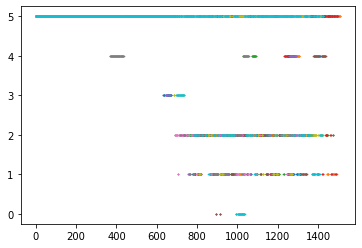

In [110]:
# plt.rcParams["figure.figsize"] = (40,20)
plt.rcParams["figure.figsize"] = (6,4)
for i in range(10): # 10
    cur_scenes = dataset[i]["scenes"]
    scatter = plt.scatter(list(range(cur_scenes.shape[0])), cur_scenes["scene"], s=0.5)
# plt.gca().invert_yaxis()

## Sanity Tests

### Get Global Intent Regions (Past, Present, Future)

In [111]:
global_region_mult = 2
map_dim  = 16_000
map_width = map_height = map_dim
map_n = int(map_dim / 1000) * global_region_mult
global_intent_region_size = int(map_dim / map_n)
print("Map Region Count, Map Region Size:", map_n, (global_intent_region_size, global_intent_region_size))

Map Region Count, Map Region Size: 32 (500, 500)


In [112]:
OBS_PREV = 4 # NOTE: Make this slightly less than one second on average

def get_global_intent_regions(row):
    # Gets `N` global intent region for current row for champ
    x_n = math.floor(interp(row[7], [0, 16000], [0, map_n-1]))
    y_n = math.floor(interp(row[9], [0, 16000], [0, map_n-1]))
    return y_n * map_n + x_n

# Get Past, Current and Future Global Intent Regions
global_intent_regions = champs.apply(\
    lambda row: get_global_intent_regions(row), axis=1)
global_intent_regions_prev = global_intent_regions.copy().shift(-OBS_PREV).fillna(0)
global_intent_regions_future = global_intent_regions.copy().shift(+OBS_PREV).fillna(0)

### Get Observations

In [119]:
# For Each Champ  := 
# (0 - HP, 7 - X, 9 - Y, 30 - Lvl, 62 - xdiff, 63 - zdiff, 64 - xzdiff, [q,w,e,r,d,f]_cd=14,16,18,20,23)

# For Each Minion := (0 - HP, 7 - X, 9 - Y, 14 - xdiff, 15 - zdiff, 16 - xzdiff)

#champ_indices  = [0, 7, 9, 30, 62, 63, 64, 15, 17, 19, 21, 23, 26]
#minion_indices = [0, 7, 9, 14, 15, 16]

champ_indices  = [0, 7, 9, 30, 62, 63, 64]
minion_indices = [7, 9]

def get_obs(dataset, champ_indices, minion_indices):
    lst = []
    for d in range(100):
    # for d in range(len(dataset)):
        example = dataset[d]

        champs  = example["champs"]
        minions = example["minions"]

        tm    = example["raw"].iloc[:, 0]
        spawn = example["raw"].iloc[:, 1]

        champ_feats  = []
        minion_feats = []

        for i in range(10): # UNIT_COUNTS["champs"]):
            base = i * UNIT_FEATURE_COUNTS["champs"]
            feats = [champs.iloc[:, base + idx] for idx in champ_indices]
            champ_feats.append(feats)

        for i in range(1): # UNIT_COUNTS["minions"]):
            base = i * UNIT_FEATURE_COUNTS["minions"]
            feats = [minions.iloc[:, base + idx] for idx in minion_indices]
            minion_feats.append(feats)
        
        champ_feats_df = pd.concat(champ_feats[0], axis=1)
        for feat in champ_feats[1:]:
            cur_feats = pd.concat(feat, axis=1)
            champ_feats_df = pd.concat([champ_feats_df, cur_feats], axis=1)

        minion_feats_df = pd.concat(minion_feats[0], axis=1)
        for feat in minion_feats[1:]:
            cur_feats = pd.concat(feat, axis=1)
            minion_feats_df = pd.concat([minion_feats_df, cur_feats], axis=1)

        global_intent_regions = champs.apply(\
            lambda row: get_global_intent_regions(row), axis=1)
        global_intent_regions_prev = global_intent_regions.copy().shift(-OBS_PREV).fillna(0)
        global_intent_regions_future = global_intent_regions.copy().shift(+OBS_PREV).fillna(0)

        print(
            d,
            tm.shape,
            spawn.shape,
            champ_feats_df.shape,
            minion_feats_df.shape,
            global_intent_regions_prev.shape,
            global_intent_regions.shape,
            global_intent_regions_future.shape)
        
        lst.append([
            tm,
            spawn,
            champ_feats_df, \
            minion_feats_df, \
            global_intent_regions_prev, \
            global_intent_regions, \
            global_intent_regions_future])

    return lst

# champ_feats_df, minion_feats_df, global_prev, global_cur, global_next = get_obs(dataset)
processed_obs_s = get_obs(
                    dataset,
                    champ_indices=champ_indices,
                    minion_indices=minion_indices)

0 (1410,) (1410,) (1410, 70) (1410, 2) (1410,) (1410,) (1410,)
1 (1510,) (1510,) (1510, 70) (1510, 2) (1510,) (1510,) (1510,)
2 (1477,) (1477,) (1477, 70) (1477, 2) (1477,) (1477,) (1477,)
3 (1497,) (1497,) (1497, 70) (1497, 2) (1497,) (1497,) (1497,)
4 (1373,) (1373,) (1373, 70) (1373, 2) (1373,) (1373,) (1373,)
5 (1438,) (1438,) (1438, 70) (1438, 2) (1438,) (1438,) (1438,)
6 (1360,) (1360,) (1360, 70) (1360, 2) (1360,) (1360,) (1360,)
7 (1391,) (1391,) (1391, 70) (1391, 2) (1391,) (1391,) (1391,)
8 (1425,) (1425,) (1425, 70) (1425, 2) (1425,) (1425,) (1425,)
9 (1426,) (1426,) (1426, 70) (1426, 2) (1426,) (1426,) (1426,)
10 (1463,) (1463,) (1463, 70) (1463, 2) (1463,) (1463,) (1463,)
11 (1453,) (1453,) (1453, 70) (1453, 2) (1453,) (1453,) (1453,)
12 (1436,) (1436,) (1436, 70) (1436, 2) (1436,) (1436,) (1436,)
13 (1333,) (1333,) (1333, 70) (1333, 2) (1333,) (1333,) (1333,)
14 (1443,) (1443,) (1443, 70) (1443, 2) (1443,) (1443,) (1443,)
15 (1480,) (1480,) (1480, 70) (1480, 2) (1480,) (1

### Dataset

In [120]:
# obs = pd.concat([champ_feats_df, minion_feats_df, global_prev, global_cur], axis=1)
# obs = pd.concat([champ_feats_df, global_prev, global_cur], axis=1)
# act = pd.concat([global_next], axis=1)

obs_s = [pd.concat(obs[:-1], axis=1)
         for obs in processed_obs_s]
act_s = [pd.concat(obs[-1:], axis=1)
         for obs in processed_obs_s]

In [83]:

act_s = [act.iloc[:, -2:]
         for act in [dataset[i]["act"] for i in range(10)]]

In [115]:
# obs_s[0],
act_s[0]

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1405,151.0
1406,151.0
1407,151.0
1408,151.0


In [25]:
# ex = (obs_s[0].iloc[:, 1] - np.asarray(obs_s[0].iloc[:, 1], dtype=np.float32).mean()) / (np.asarray(obs_s[0].iloc[:, 1], dtype=np.float32).std())
# ex

### Movement Prediction

#### Current and Future Global Intent Region Correlation

1
2
3
4
5
6
7
8
9
10


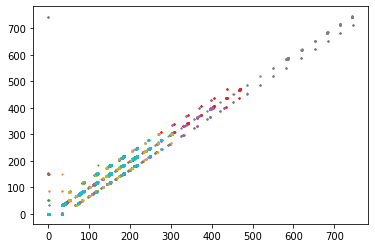

In [116]:
i = 0
for obs, act in zip(obs_s, act_s):
    i += 1
    print(i)
    x = obs.iloc[:, -1] # Present
    y = act.iloc[:, 0]  # Future
    plt.scatter(x, y, s=1)
i = 0

#### Dataset - Prev and Current Global Intent Region Correlation

In [121]:
corr_s = obs
corr_s["future_global"] = act
corr_s = corr_s.corr()

for obs, act in list(zip(obs_s, act_s))[1:]:
    cur = obs
    cur["future_global"] = act
    cur = cur.corr()
    corr_s += cur

print("OBS_DIFF GLOBAL:", OBS_PREV)

total_corr = corr_s / 100
total_corr

OBS_DIFF GLOBAL: 4


,time,minion_spawn_countdown,health_0,position_x_0,position_z_0,level_0,x_diff_from_player_0,z_diff_from_player_0,x_z_diff_from_player_0,health_1,...,position_z_5_,level_5,x_diff_from_player_5_,z_diff_from_player_5_,x_z_diff_from_player_5_,position_x___,position_z___,0,1,future_global
time,1.000000,-0.477483,-0.153114,0.535418,-0.065520,0.920865,NaN,NaN,NaN,-0.095827,...,0.537219,0.925029,-0.553347,0.586315,0.714637,0.779746,0.676925,-0.030250,-0.011675,-0.002225
minion_spawn_countdown,-0.477483,1.000000,0.080640,-0.643249,-0.385057,-0.294687,NaN,NaN,NaN,0.088347,...,-0.644084,-0.290456,0.535600,-0.563665,-0.674591,-0.478554,-0.405453,-0.409020,-0.425728,-0.435259
health_0,-0.153114,0.080640,1.000000,-0.222281,0.008865,-0.093588,NaN,NaN,NaN,0.316382,...,-0.131088,-0.111537,0.233292,-0.138083,-0.205889,-0.261999,-0.217127,0.000773,-0.010196,-0.017818
position_x_0,0.535418,-0.643249,-0.222281,1.000000,0.442657,0.360599,NaN,NaN,NaN,-0.207647,...,0.659072,0.349120,-0.917189,0.574439,0.838058,0.684084,0.561655,0.492255,0.509245,0.508443
position_z_0,-0.065520,-0.385057,0.008865,0.442657,1.000000,-0.127633,NaN,NaN,NaN,-0.007883,...,0.294379,-0.153948,-0.319947,0.016725,0.199071,0.011664,0.144752,0.973484,0.986801,0.977608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
position_x___,0.779746,-0.478554,-0.261999,0.684084,0.011664,0.586729,NaN,NaN,NaN,-0.212521,...,0.596521,0.580746,-0.702309,0.628334,0.771382,1.000000,0.829734,0.052522,0.069260,0.076926
position_z___,0.676925,-0.405453,-0.217127,0.561655,0.144752,0.516293,NaN,NaN,NaN,-0.170967,...,0.524750,0.496215,-0.570046,0.513970,0.656770,0.829734,1.000000,0.167841,0.186326,0.199392
0,-0.030250,-0.409020,0.000773,0.492255,0.973484,-0.103135,NaN,NaN,NaN,-0.021058,...,0.329168,-0.127762,-0.365817,0.060319,0.251846,0.052522,0.167841,1.000000,0.976084,0.960771
1,-0.011675,-0.425728,-0.010196,0.509245,0.986801,-0.086757,NaN,NaN,NaN,-0.024473,...,0.341089,-0.112063,-0.382482,0.068779,0.266355,0.069260,0.186326,0.976084,1.000000,0.980662


In [67]:
A_x_corr_s = total_corr["position_x_0"].sort_values()
A_x_corr_s

x_diff_from_player_4___   -0.889013
x_diff_from_player_5_     -0.889013
x_diff_from_player_4___   -0.767720
x_diff_from_player_3___   -0.767720
x_diff_from_player_3___   -0.730866
                             ...   
r_cd_3__                        NaN
r_cd_4__                        NaN
w_cd_5                          NaN
e_cd_5                          NaN
r_cd_5                          NaN
Name: position_x_0, Length: 137, dtype: float64

In [68]:
A_y_corr_s = total_corr["position_z_0"].sort_values()
A_y_corr_s

minion_spawn_countdown   -0.356442
d_cd_0                   -0.339505
d_cd__                   -0.339505
f_cd_0                   -0.332804
f_cd__                   -0.332804
                            ...   
r_cd_3__                       NaN
r_cd_4__                       NaN
w_cd_5                         NaN
e_cd_5                         NaN
r_cd_5                         NaN
Name: position_z_0, Length: 137, dtype: float64

In [122]:
A_future_corr_s = total_corr["future_global"].sort_values()
A_future_corr_s

minion_spawn_countdown    -0.435259
x_diff_from_player_5_     -0.379047
x_diff_from_player_4___   -0.378211
x_diff_from_player_4___   -0.285203
x_diff_from_player_3___   -0.284163
                             ...   
z_diff_from_player_0            NaN
x_z_diff_from_player_0          NaN
x_diff_from_player___           NaN
z_diff_from_player___           NaN
x_z_diff_from_player___         NaN
Name: future_global, Length: 77, dtype: float64

#### Obs, Act Correlates

In [84]:
A_obs_act_corr_s = pd.concat((obs_s[0], act_s[0]), axis=1).corr()
A_obs_act_corr_s

,time,minion_spawn_countdown,health_0,position_x_0,position_z_0,level_0,x_diff_from_player_0,z_diff_from_player_0,x_z_diff_from_player_0,health_1,...,level_5,x_diff_from_player_5_,z_diff_from_player_5_,x_z_diff_from_player_5_,position_x___,position_z___,0,1,movement_x_delta_digital,movement_z_delta_digital
time,1.000000,-0.468246,0.546450,0.879411,0.056158,0.925010,NaN,NaN,NaN,0.005405,...,0.927943,-0.851893,0.773421,0.860732,0.888814,0.706215,0.151683,0.173854,-0.158381,-0.031526
minion_spawn_countdown,-0.468246,1.000000,-0.317823,-0.602721,-0.419921,-0.282814,NaN,NaN,NaN,0.218768,...,-0.279844,0.509725,-0.517561,-0.549529,-0.486181,-0.306955,-0.465725,-0.479644,0.201560,0.006307
health_0,0.546450,-0.317823,1.000000,0.522967,-0.019920,0.587768,NaN,NaN,NaN,-0.023814,...,0.541301,-0.528799,0.411016,0.513760,0.455495,0.299857,0.044190,0.069241,-0.093349,-0.049872
position_x_0,0.879411,-0.602721,0.522967,1.000000,0.136842,0.723548,NaN,NaN,NaN,-0.220790,...,0.733120,-0.972970,0.763159,0.965844,0.853550,0.608653,0.251079,0.265625,-0.139912,-0.022910
position_z_0,0.056158,-0.419921,-0.019920,0.136842,1.000000,0.027009,NaN,NaN,NaN,0.299651,...,0.010652,-0.040092,-0.147357,-0.036915,-0.091947,0.210308,0.961942,0.974802,-0.158667,-0.019297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
position_z___,0.706215,-0.306955,0.299857,0.608653,0.210308,0.582605,NaN,NaN,NaN,0.090063,...,0.562550,-0.550118,0.681962,0.642193,0.726163,1.000000,0.285066,0.306315,-0.095209,-0.086886
0,0.151683,-0.465725,0.044190,0.251079,0.961942,0.099564,NaN,NaN,NaN,0.237764,...,0.088560,-0.139805,-0.027877,0.077877,0.020537,0.285066,1.000000,0.971249,-0.139039,0.003432
1,0.173854,-0.479644,0.069241,0.265625,0.974802,0.119368,NaN,NaN,NaN,0.255815,...,0.106917,-0.154055,-0.010517,0.094551,0.035966,0.306315,0.971249,1.000000,-0.157544,-0.018322
movement_x_delta_digital,-0.158381,0.201560,-0.093349,-0.139912,-0.158667,-0.143773,NaN,NaN,NaN,-0.014782,...,-0.122367,0.120413,-0.075794,-0.109358,-0.094853,-0.095209,-0.139039,-0.157544,1.000000,0.113934


In [89]:
A_move_x_corr_sorted = A_obs_act_corr_s["movement_x_delta_digital"].sort_values()

In [90]:
A_move_y_corr_sorted = A_obs_act_corr_s["movement_z_delta_digital"].sort_values()

In [91]:
A_future_global_corr_sorted = A_obs_act_corr_s["future_global"].sort_values()

KeyError: 'future_global'